In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

## Import dataset 

In [2]:
import pandas as pd
le_serra_tweets = pd.read_csv("C:/Users/User/Downloads/le_serrafim.csv")

In [3]:
le_serra_tweets.head() #retrieve first 5 rows of the dataset

,id,text,created_at,lang
0,1529697654334115842,Hybe successfully take the spotlight from Gar...,2022-05-26 05:35:15+00:00,en
1,1529697612659470336,jnklaina Im literally shock as well IDK if it...,2022-05-26 05:35:05+00:00,en
2,1529697533580427265,GIVEAWAY SPECIAL TH ANNIVERSARY SEVENTEEN CAR...,2022-05-26 05:34:47+00:00,en
3,1529697452336369664,Thank god hybe doesnt gaf about yalls ridicul...,2022-05-26 05:34:27+00:00,en
4,1529697307616088064,Tae got mad during that time when mfs invaded...,2022-05-26 05:33:53+00:00,en


## EDA

### Check for null values 

In [4]:
le_serra_tweets.isnull().sum() #no null values detected 

id            0
text          0
created_at    0
lang          0
dtype: int64

### Show top words used

In [5]:
import numpy as np 

def top_n_words(n_top_words, count_vectorizer, text_data):
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [str(word[0]) for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

In [8]:
reindexed_data = le_serra_tweets['text']


C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47476 (\N{HANGUL SYLLABLE REU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54604 (\N{HANGUL SYLLABLE PIM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


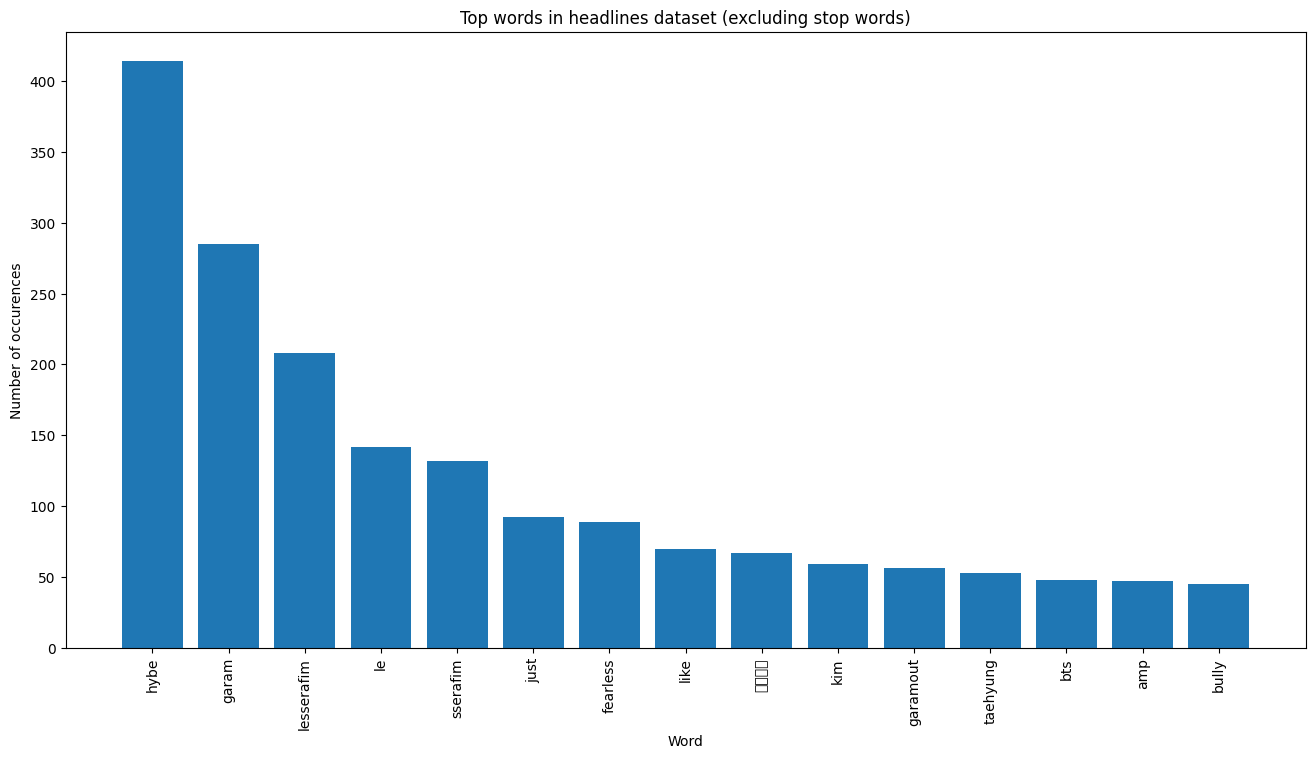

In [18]:
from sklearn.feature_extraction.text import CountVectorizer #convert text into a vector of real numbers 
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

The top 10 words in the dataset are mostly about Le Serrafim, a kpop girl group. However, there are also words such as 'taehyung' and 'bts' which is related to another pop group in Korea. 

## Preprocessing

### Convert text to lowercase

In [6]:
le_serra_tweets['text'] = le_serra_tweets['text'].str.lower()

In [6]:
le_serra_tweets['text']

0        hybe successfully take the spotlight from gar...
1        jnklaina im literally shock as well idk if it...
2        giveaway special th anniversary seventeen car...
3        thank god hybe doesnt gaf about yalls ridicul...
4        tae got mad during that time when mfs invaded...
                              ...                        
1035                                            who cares
1036                            garam bullygaram out hybe
1037      i love listening to lies when i know the truth.
1038                omg - what a great debut but pls kick
1039    : i love listening to lies when i know the truth.
Name: text, Length: 1040, dtype: object

### Tokenization

process of breaking text into words

In [7]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [8]:
def sent_to_words(sentences, deacc=True): # deacc=True removes punctuations
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  


# convert to list
data = le_serra_tweets['text'].values.tolist()
data_words = list(sent_to_words(data))

### Stop word removal

In [9]:
#create a list of stop words (irrelevant words that don't carry information)  
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english') + list(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#function to remove stopwords 
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

### Lemmatization

In [11]:
#lemmatization - get root form of the word 
# function to lemmatize text 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
import spacy
data_words_nostops = remove_stopwords(data_words) #remove stop words 

# Load the spaCy 'en' model with only the tagger component enabled (disabling parser and named entity recognition)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [13]:
print(' '.join(data_words[0]), '\n') #tokenization
print(' '.join(data_words_nostops[0]), '\n') #remove stop words 
print(' '.join(data_lemmatized[0])) # lemmatization

hybe successfully take the spotlight from garam and throw taehyung and jennie under the bus they really need of the top 

hybe successfully take spotlight garam throw taehyung jennie bus really need top 

hybe successfully take spotlight throw really need top


## Sentiment Analysis using VADER

Vader (Valence Aware Dictionary for Sentiment Reasoning)
- sensitive to polarity and strength of emotion
- each words in the lexicon is rated how positive or negative it is 

Compound Score in VADER Sentiment Analysis
- calcultaes the sum of all lexicon ratings normalized between -1 (most extreme negative) and + 1(most extreme positive)

In [14]:
tweets_df = le_serra_tweets.copy() #make a copy of the original df and add columns for preprocessed text  
tweets_df['tokenized'] = data_words
tweets_df['no_stopwords'] = data_words_nostops
tweets_df['lemmatized'] = data_lemmatized

In [15]:
#join list items in lemmatized so that it will be in a sentence/phrase form
def join_tokens(token_list):
    return ' '.join(token_list)
tweets_df['lemmatized'] = tweets_df['lemmatized'].apply(join_tokens)

In [16]:
tweets_df.head()

,id,text,created_at,lang,tokenized,no_stopwords,lemmatized
0,1529697654334115842,hybe successfully take the spotlight from gar...,2022-05-26 05:35:15+00:00,en,"[hybe, successfully, take, the, spotlight, fro...","[hybe, successfully, take, spotlight, garam, t...",hybe successfully take spotlight throw really ...
1,1529697612659470336,jnklaina im literally shock as well idk if it...,2022-05-26 05:35:05+00:00,en,"[jnklaina, im, literally, shock, as, well, idk...","[jnklaina, im, literally, shock, well, idk, re...",m literally shock real think rumor solve hybe ...
2,1529697533580427265,giveaway special th anniversary seventeen car...,2022-05-26 05:34:47+00:00,en,"[giveaway, special, th, anniversary, seventeen...","[giveaway, special, th, anniversary, seventeen...",giveaway special anniversary choice postcard h...
3,1529697452336369664,thank god hybe doesnt gaf about yalls ridicul...,2022-05-26 05:34:27+00:00,en,"[thank, god, hybe, doesnt, gaf, about, yalls, ...","[thank, god, hybe, doesnt, gaf, yalls, ridicul...",thank hybe yall ridiculous opinion
4,1529697307616088064,tae got mad during that time when mfs invaded...,2022-05-26 05:33:53+00:00,en,"[tae, got, mad, during, that, time, when, mfs,...","[tae, got, mad, time, mfs, invaded, privacy, c...",get mad time invade privacy come rumor mind bu...


In [17]:
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vad


tf_data=TfidfVectorizer() #initialize tf-idf
vader=tweets_df.copy() #creates a copy of the dataframe and assigns it to vader 

sentiment=vad() # initializes a VADER sentiment analyzer
# Making additional columns for sentiment score in the vader dataframe
sen=['Positive','Negative','Neutral']
#calculate sentiment scores (pos,neg,neutral) for each text in the vader['lemmatized'] column (use the preprocessed data)
sentiments=[sentiment.polarity_scores(i) for i in vader['lemmatized'].values]
#the calculated scores will be stored in negative_score, positive_score, neutral_score, and compound_score columns
vader['Negative Score']=[i['neg'] for i in sentiments]
vader['Positive Score']=[i['pos'] for i in sentiments]
vader['Neutral Score']=[i['neu'] for i in sentiments]
vader['Compound Score']=[i['compound'] for i in sentiments]

#overall sentiment determination
#determines the overall sentiment label ('Positive', 'Negative', 'Neutral') based on the 'Compound Score' column
score=vader['Compound Score'].values
t=[]
for i in score:
    if i >=0.05 :
        t.append('Positive')
    elif i<=-0.05 :
        t.append('Negative')
    else:
        t.append('Neutral')
vader['Overall Sentiment']=t


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
vader.head()

,id,text,created_at,lang,tokenized,no_stopwords,lemmatized,Negative Score,Positive Score,Neutral Score,Compound Score,Overall Sentiment
0,1529697654334115842,hybe successfully take the spotlight from gar...,2022-05-26 05:35:15+00:00,en,"[hybe, successfully, take, the, spotlight, fro...","[hybe, successfully, take, spotlight, garam, t...",hybe successfully take spotlight throw really ...,0.000,0.468,0.532,0.6461,Positive
1,1529697612659470336,jnklaina im literally shock as well idk if it...,2022-05-26 05:35:05+00:00,en,"[jnklaina, im, literally, shock, as, well, idk...","[jnklaina, im, literally, shock, well, idk, re...",m literally shock real think rumor solve hybe ...,0.250,0.173,0.577,-0.2023,Negative
2,1529697533580427265,giveaway special th anniversary seventeen car...,2022-05-26 05:34:47+00:00,en,"[giveaway, special, th, anniversary, seventeen...","[giveaway, special, th, anniversary, seventeen...",giveaway special anniversary choice postcard h...,0.000,0.278,0.722,0.4019,Positive
3,1529697452336369664,thank god hybe doesnt gaf about yalls ridicul...,2022-05-26 05:34:27+00:00,en,"[thank, god, hybe, doesnt, gaf, about, yalls, ...","[thank, god, hybe, doesnt, gaf, yalls, ridicul...",thank hybe yall ridiculous opinion,0.312,0.312,0.375,0.0000,Neutral
4,1529697307616088064,tae got mad during that time when mfs invaded...,2022-05-26 05:33:53+00:00,en,"[tae, got, mad, during, that, time, when, mfs,...","[tae, got, mad, time, mfs, invaded, privacy, c...",get mad time invade privacy come rumor mind bu...,0.286,0.000,0.714,-0.4939,Negative


### Visualize sentiment scores

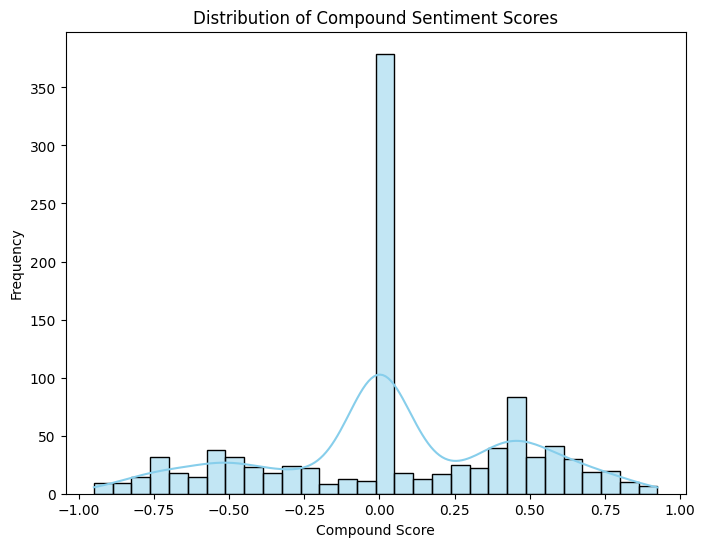

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of Compound Score distribution
plt.figure(figsize=(8, 6))
sns.histplot(vader['Compound Score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.show()


The histogram plot shows the distribution of the compound scores. It can be observed that the score of 0.00 has obtained the highest frequency of more than 350, followed by a score of 0.50 with a frequency of almost 100. The plot is skewed to the left signifiying that the lump of data is labelled as neutral or positive.  

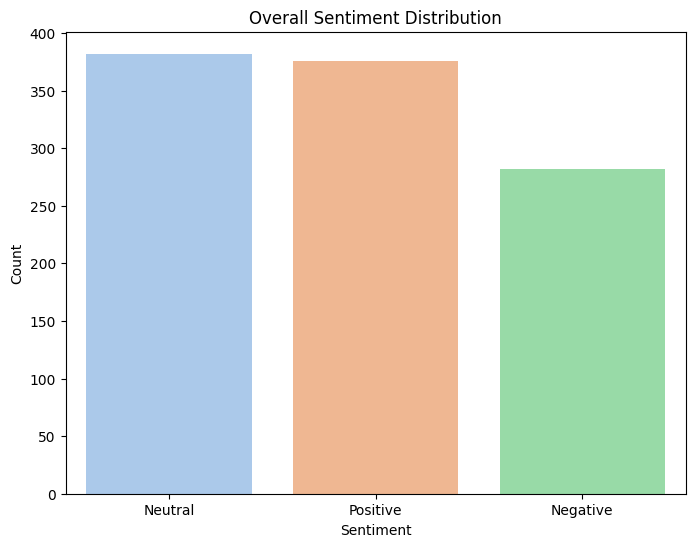

In [20]:
# Count overall sentiment categories
sentiment_counts = vader['Overall Sentiment'].value_counts()

# Plot bar chart of sentiment counts
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel')
plt.title('Overall Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


The figure shows that majority of the tweets are labelled as neutral sentiments, indicating a compound score of between -0.05 and 0.05. Positive sentiments come in second with texts having a compound score of greater than 0.05. Negative sentiments come in last with texts having a compound score of less than 0.05. 

## Topic Modelling using LDA

In [51]:
#make a corpus from the lemmatized words 
corpus = [item for sublist in data_lemmatized for item in sublist]

#### Create a dictionary

In [58]:
#create a dictionary - mapping of words to unique integer IDs 
#formed form a collection of text data and contains vocabulary of words used in text data 
# Optionally filter out words that are too rare or too frequent
from gensim import corpora
dictionary = corpora.Dictionary(data_lemmatized)

#### Create a corpus

In [62]:
#create corpus
corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]

#### Create a transformation

In [63]:
from gensim import corpora, models, similarities
tfidf = models.TfidfModel(corpus)

In [65]:
#use the model to transform vectors
corpus_tfidf = tfidf[corpus] 

#### LDA

In [24]:
total_topics = 5

* corpus - corpus of documents for training LDA model (word_id, word_count)
* id2word = dictionary - used to map words IDs (integer IDs)
* dictionary - passed to LDA for topic-word distributions

In [67]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] #generate topic distribuions for each document in the corpus_tfidf based in the learned topic-word distributions from LDA model

In [68]:
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

[(0,
  '0.017*"lesserafim" + 0.017*"sserafim" + 0.014*"hybe" + 0.010*"even" + 0.009*"group"'),
 (1,
  '0.051*"hybe" + 0.011*"make" + 0.008*"people" + 0.007*"garamout" + 0.007*"know"'),
 (2,
  '0.061*"lesserafim" + 0.038*"hybe" + 0.018*"fearless" + 0.013*"sserafim" + 0.012*"르세라핌"'),
 (3,
  '0.053*"hybe" + 0.013*"bully" + 0.011*"get" + 0.009*"victim" + 0.009*"say"'),
 (4,
  '0.024*"sserafim" + 0.017*"hybe" + 0.010*"go" + 0.009*"get" + 0.009*"lesserafim"')]

In [69]:
#each key 'i' refers to a topic ID ranging from 0 to total_topics[-1]
#(i,25) creates a OrderedDIct contianing the top 25 words 
from collections import OrderedDict
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}

In [70]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(5, 69)


In [73]:
df_lda

,lesserafim,sserafim,hybe,even,group,song,show,ve,think,get,...,also,need,case,see,wear,garambully,sakura,vote,talk,fake
0,0.016760,0.016542,0.013924,0.009575,0.008611,0.008073,0.007580,0.007502,0.005921,0.005490,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.005228,0.006123,0.050793,0.004722,0.000000,0.000000,0.004786,0.004071,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.060674,0.012689,0.038362,0.000000,0.000000,0.000000,0.000000,0.005476,0.000000,0.003802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.005064,0.052938,0.000000,0.006514,0.000000,0.000000,0.000000,0.008346,0.011347,...,0.004191,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.008601,0.024025,0.016961,0.000000,0.004288,0.000000,0.004406,0.006839,0.000000,0.009063,...,0.000000,0.008565,0.008504,0.008359,0.006194,0.005839,0.00455,0.004254,0.003955,0.003775


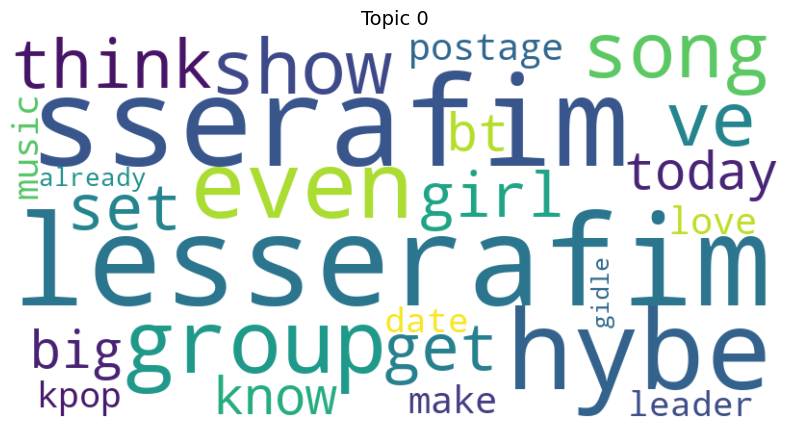

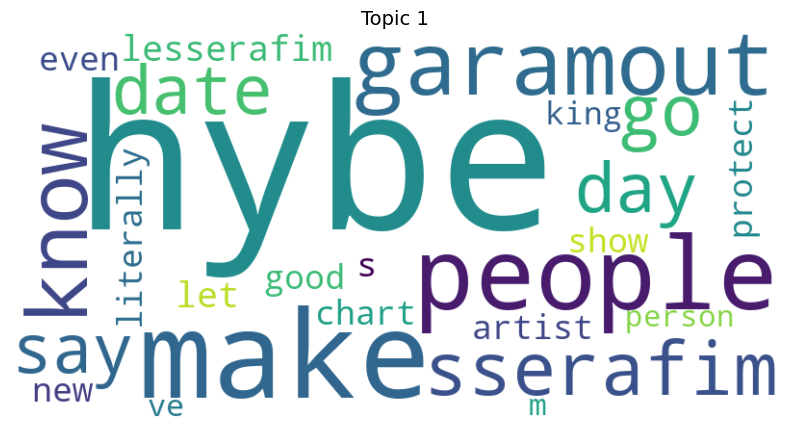

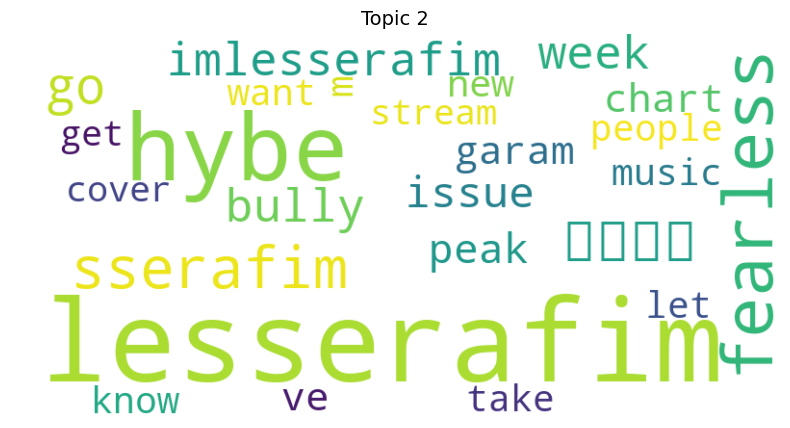

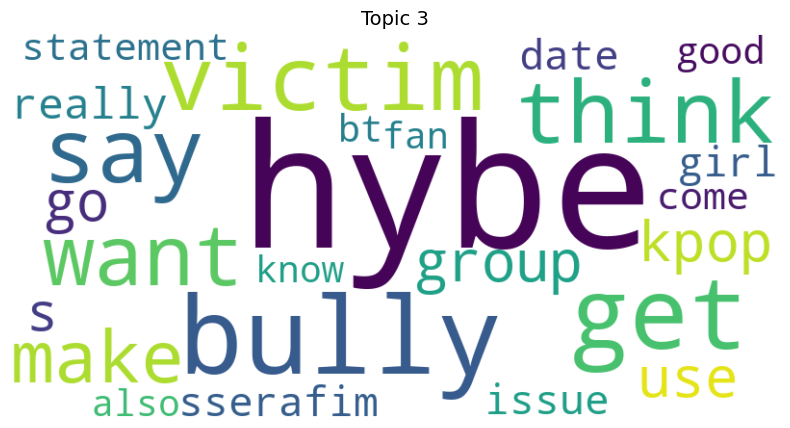

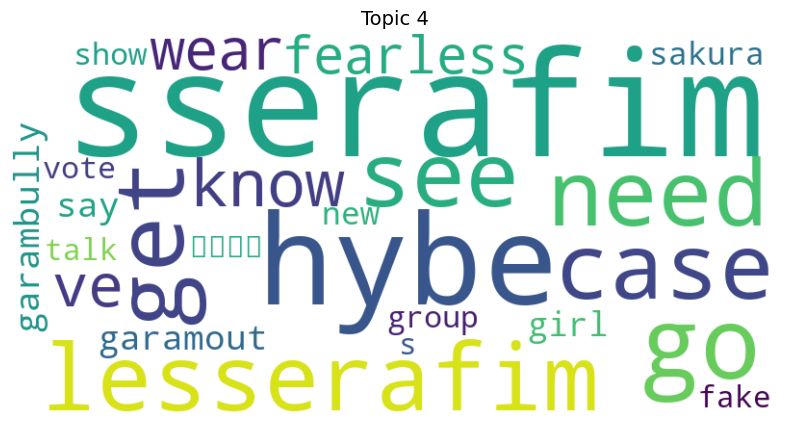

In [77]:
for topic_id, word_freq in data_lda.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
    # Plot word cloud for the current topic
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {topic_id}', fontsize=14)
    plt.axis('off')  # Hide axes
    plt.show()